# LSTM modeling of TUH_SEZ EEG dataset

## Data Source

The TUH EEG Seizure Corpus (TUSZ): This corpus has manually EEG signals that have been carefully annotated data for seizures. For more information about this corpus, please refer to https://www.isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml

## Prerequisites 
* Download TUSZ dataset to your local machine, using the above link. This can be done using rsync, following the instruction in the download page. We need to register a username and password.
* pre-process the TUSZ dataset (Relavent notebooks in the directory)
2. insert the pre-processed data into a SQL database
3. host the SQL database via SQLengine. This can be localhost or remote on RDS, etc.


In [2]:
# !git clone https://github.com/ylin00/seizurecast
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from seizurecast.postgresql import SQLengine
from seizurecast.models.parameters import LABEL_BKG, LABEL_PRE, LABEL_SEZ

def setlabel(pres, post, len_pos=300, len_pre=300, sec_gap=600):
  """convert pres and post timestamps to background and preseizure labels"""
  y = []
  for _, (pres, post) in enumerate(zip(pres, post)):
    if post > len_pos and pres > sec_gap + len_pre:
      y.append(LABEL_BKG)
    elif post > len_pos and pres > sec_gap:
      y.append(LABEL_PRE)
    else:
      y.append(LABEL_SEZ)
  return y

## Explore the table used in this notebook

### Preprocessed training set of TCP type 01 

In [3]:
pd.read_sql("select * from preprocessed_train_tcp01 where token='00010489_s005_t009' limit 1", SQLengine).head()


,index,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,token,timestamp,post,pres
0,0,3.075307,-1.437953,-0.510054,-1.787994,-9.574326,-1.176332,-8.338621,0.81589,00010489_s005_t009,0.0,99999.0,99999.0


## Patient directory

In [4]:
print("The count of distint patient\n",pd.read_sql("select count(distinct patient) from directory", SQLengine))
print("The head of table Directory")
pd.read_sql("select * from directory limit 10", SQLengine).head()

The count of distint patient
    count
0    637
The head of table Directory


,index,path0,path1,path2,path3,path4,path5,path6,train_test,tcp_type,patient_group,patient,session,token,token_path
0,0,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t008,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
1,1,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t009,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
2,2,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t001,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
3,3,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t000,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
4,4,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t002,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...


## Labels of seizure events from experts

In [5]:
[pd.read_sql(f"""
select * from seiz_bckg 
where label='{lbl}' and train_test='train'
""", SQLengine).to_sql(f'tmp_{lbl}_train', SQLengine, if_exists='replace') for lbl in ['bckg', 'seiz']]
print(f"""Number of token containing seizures = {pd.read_sql("select count(*) from tmp_seiz_train", SQLengine).to_numpy()[0,0]}""")
print(f"""Else = {pd.read_sql("select count(*) from tmp_bckg_train", SQLengine).to_numpy()[0,0]}""")
pd.read_sql("select * from tmp_seiz_train limit 3", SQLengine).head()

Number of token containing seizures = 2370
Else = 6967


,level_0,index,token,time_start,time_end,label,prob,train_test
0,0,36,00000492_s003_t000,6.2825,35.8875,seiz,1.0,train
1,1,39,00000492_s003_t001,33.1425,53.0000,seiz,1.0,train
2,2,42,00000492_s003_t002,9.7925,29.1250,seiz,1.0,train


# Split Train Test patients

In [6]:
patient_train = pd.read_sql("select distinct patient from patient_group where train_test='train'", SQLengine)
patient_test = pd.read_sql("select distinct patient from patient_group where train_test='test'", SQLengine)
print(f"Patient ID: {patient_train[0:3]} ..., \n",
    f"Number of patients in Train:\t{patient_train.shape[0]}\n",
    f"Number of patients in Test:\t{patient_test.shape[0]}\n")

Patient ID:     patient
0  00011454
1  00008053
2  00008440 ..., 
 Number of patients in Train:	246
 Number of patients in Test:	62



In [7]:
# create table tmp_token_group storing Token and their train/test group
pd.read_sql("""
select A.train_test, B.token
from patient_group A
inner join directory B on A.patient=B.patient;
""",SQLengine).to_sql('tmp_token_group', SQLengine, if_exists='replace')

In [8]:
print("Number of Tokens in each group \n", pd.read_sql("select * from tmp_token_group", SQLengine)[['train_test','token']].groupby('train_test').count())

Number of Tokens in each group 
             token
train_test       
test          712
train        2974


## Load train/test dataset

In [15]:
def load_dataset(feature_table, token_table, len_pos, len_pre, sec_gap, limit=100, SQLengine=SQLengine):
    """
    Args:
        feature_table: feature table name
        token_table: token_table that contains train_test label
        len_pos: post seizure length in second
        len_pre: pre seizure length in second
        sec_gap: gap in second between pre-seizrue and seizure
        limit: limit of items
    """
    dataset={}
    for i, group in enumerate(['train', 'test']):
        dataset[group] = (pd.read_sql(f"""
        (
            select token, index,  ch0, ch1, ch2, ch3, ch4, ch5, ch6, ch7, post, pres
            from {feature_table} A
            where A.token in (
              select B.token from {token_table} B where B.train_test='{group}'
            ) and (
              A.pres<{sec_gap + len_pre}
              and {sec_gap}<A.pres
              and A.post>{len_pos}
            ) 
            limit {limit}
        )

        union

        (
            select token, index, ch0, ch1, ch2, ch3, ch4, ch5, ch6, ch7, post, pres 
            from {feature_table} A
            where A.token in (
              select B.token from {token_table} B where B.train_test='{group}' 
            ) and (
              {sec_gap + len_pre}<A.pres
              and A.post>{len_pos}
            )
            limit {limit}
        )
        
        order by
            token,
            index
        ;
        """, SQLengine))
    return dataset

# Consider load 'dataset.pkl' before query sql

# dataset = load_dataset('preprocessed_train_tcp01', 'tmp_token_group', 300, 600, 300, limit=1000000)
print(f"Size of Tran set = {dataset['train'].shape}; \nSize of Test set = {dataset['test'].shape}")

Size of Tran set = (2000000, 12); 
Size of Test set = (1197107, 12)


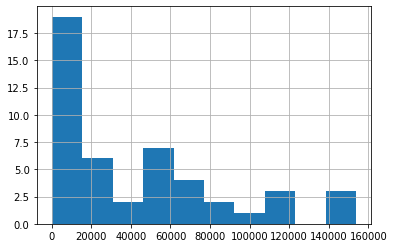

In [23]:
# import pickle
# with open('lstm_datasets.pkl', 'wb') as f:
#     pickle.dump(dataset, f)
# patient counts
dataset['train'].groupby('token')['ch0'].count().hist()

## Balance Data

I balance data using subsampling, weighted by the number of samples each patient has, i.e., the more samples a patient has in the dataset, the less likely each sample will be selected.   

Patient numbers in the train test

In [24]:
dirs = pd.read_sql("select token, patient from directory", SQLengine)
print("number of patients in train/test")
pd.concat(dataset)\
    .loc[:,['token']]\
    .drop_duplicates()\
    .reset_index()\
    .merge(dirs, how='left')\
    .set_index(['level_0','level_1'])\
    .groupby('level_0')['patient'].nunique()

number of patients in train/test


level_0
test      8
train    21
Name: patient, dtype: int64

Histogram of patients and their representation in the dataset


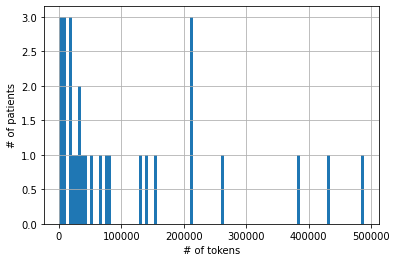

In [31]:
print("Histogram of patients and their representation in the dataset")
patient_count = pd.concat(dataset)\
    .drop_duplicates()\
    .reset_index()\
    .merge(dirs, how='left')\
    .set_index(['level_0','patient'])\
    .loc[:,'ch0']\
    .groupby(['level_0', 'patient']).count()
_ = patient_count.hist(bins=100)
_=plt.xlabel("# of tokens")
_=plt.ylabel("# of patients")

Before balance 
                  index
level_0 label         
test    bckg   1000000
        pres    197107
train   bckg   1000000
        pres   1000000


After balance 
                     index  patient
train_test label                  
test       bckg    197107   197107
           pres    197107   197107
train      bckg   1000000  1000000
           pres   1000000  1000000


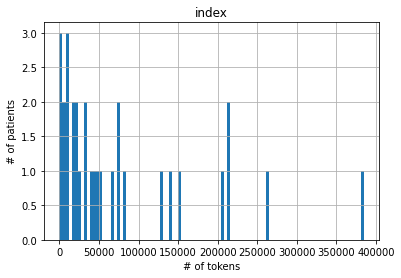

In [32]:
print(
    'Before balance \n',
    pd.concat(dataset)
        .reset_index()
        .set_index(['level_0'])
        .assign(label = lambda x: setlabel(x.pres, x.post, len_pos=300, len_pre=600, sec_gap=300))
        .loc[:,['label','index']]
        .groupby(['level_0','label'])
        .count()
)

def balance_df(df):
    """Credit=https://stackoverflow.com/a/45839920/13653455"""
    g = df.groupby(['train_test','label'])
    return g.apply(lambda x: x.sample(g.size().min(), weights=1/x['count']).reset_index(drop=True)).drop(['token','label'],axis=1)

ds_balanced = pd.concat([
        pd.concat(dataset, names=['train_test'])
        .query(f"train_test == '{g}'")
        .assign(label = lambda x: setlabel(x.pres, x.post, len_pos=300, len_pre=600, sec_gap=300))
        .reset_index()
        .merge(dirs, how='left')
        .merge(patient_count.reset_index(name="count").loc[:,['patient', 'count']], how='left')
        .set_index(['train_test', 'level_1'])
        .pipe(balance_df)

        for g in ['train', 'test']
    ])

print("\n")
print(
    "After balance \n",
    
    ds_balanced
        .loc[:,['index', 'patient']]
        .groupby(['train_test', 'label'])
        .count()
)
_=(
    ds_balanced
        .loc[:,['index', 'patient']]
        .groupby(['train_test', 'label', 'patient'])
        .count().hist(bins=100)
)
_=plt.xlabel("# of tokens")
_=plt.ylabel("# of patients")

In [34]:
dataset['train'].sort_values(['token','index']).head()

,token,index,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,post,pres
0,00000272_s008_t000,18861,10.677222,-6.066167,7.882854,-0.134612,4.325849,12.480474,2.885084,-0.729041,99999.0,99999.0
1,00000272_s008_t000,18862,10.419900,-6.127312,7.561907,-0.081029,2.249043,10.969098,2.678633,-0.473343,99999.0,99999.0
2,00000272_s008_t000,18863,9.482330,-6.045136,6.535001,-0.039715,-0.083146,9.352471,2.374690,-0.247618,99999.0,99999.0
3,00000272_s008_t000,18864,8.015557,-5.817713,4.987040,-0.009273,-2.568175,7.710565,2.046552,-0.051324,99999.0,99999.0
4,00000272_s008_t000,18865,6.229682,-5.450152,3.160334,0.011856,-5.070875,6.124346,1.771425,0.114168,99999.0,99999.0


# Training

### Scaling

After removing spikes, the majority of the features are within a range of -20 to 20 (micro Vol). Let's scale them by 1/50 and normalize them.

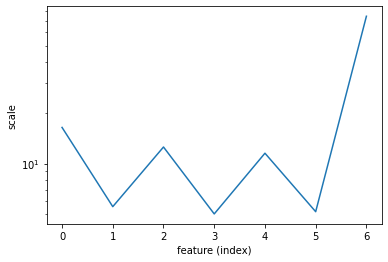

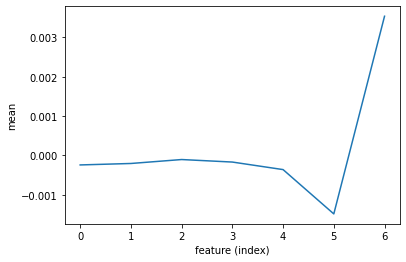

In [121]:
from sklearn import preprocessing
scalers = preprocessing.StandardScaler()
dataset['train'][['ch'+str(i) for i in range(0,7)]] = scalers.fit_transform(dataset['train'][['ch'+str(i) for i in range(0,7)]])
dataset['test'][['ch'+str(i) for i in range(0,7)]] = scalers.transform(dataset['test'][['ch'+str(i) for i in range(0,7)]])
_=plt.plot(scalers.scale_)
_=plt.yscale('log')
_=plt.ylabel('scale')
_=plt.xlabel('feature (index)')
_=plt.figure()
_=plt.plot(scalers.mean_)
_=plt.ylabel('mean')
_=plt.xlabel('feature (index)')

### Convert to 256 Hz

In [122]:
def chop_signal(long_vec, width=256, stepsize=64):
    """Chop a long long vector into 2D numpy array of width, consecutive rows will have certain overlap
    
    Args:
        long_vec: long vector
        width(int): width of the result. Must no greater than length of long_vec 
        overlap(int): Must less than width. 
    """
    if len(long_vec) < width + 1:
        return np.array([])
    long_vec = np.hstack([long_vec[i:i+width] for i in np.arange(0, len(long_vec)-width, stepsize)])
    return np.reshape(long_vec[0:(len(long_vec)//width*width)], [-1, width])

chop_signal([1, 2, 3, 4, 5], width=4, stepsize=2)

array([[1, 2, 3, 4]])

In [123]:
df.tail()

,token,index,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,post,pres
1999995,00013095_s001_t001,51713,-1.237283,-0.626019,-0.781764,-0.617996,-2.920426,-0.611279,-0.179264,2.629547,99999.0,300.019531
1999996,00013095_s001_t001,51714,-1.189601,-0.346392,-0.694781,-0.929344,-3.167448,-0.729362,-0.207865,3.249464,99999.0,300.015625
1999997,00013095_s001_t001,51715,-1.133537,-0.012338,-0.570440,-1.238498,-3.332084,-0.832942,-0.227244,3.877042,99999.0,300.011719
1999998,00013095_s001_t001,51716,-1.076370,0.365939,-0.419448,-1.528253,-3.409832,-0.912977,-0.236957,4.454287,99999.0,300.007812
1999999,00013095_s001_t001,51717,-1.025810,0.774743,-0.255645,-1.782458,-3.403461,-0.961724,-0.237403,4.924129,99999.0,300.003906


In [163]:
len_pos, len_pre, sec_gap = 300, 300, 600

def get_dataset(df, len_pos=len_pos, len_pre=len_pre, sec_gap=sec_gap):
    df = df\
    .assign(label = lambda x: setlabel(x.pres, x.post, len_pos=len_pos, len_pre=len_pre, sec_gap=sec_gap))\
    .loc[lambda df: 
         df.token.isin(
             df\
                .groupby('token')\
                .count()\
                .reset_index()\
                .loc[lambda df: df['index'] > 256]\
                .loc[:, ['token']].to_numpy().flatten()
         )]\
    .loc[:,['token', 'label', 'ch0']]\
    .groupby(['token', 'label'])\
    .apply(lambda df: pd.DataFrame(chop_signal(df['ch0'].to_numpy(), 256, 32)))\
    .reset_index()
    return df.iloc[:, 3:259], df.iloc[:, 1]

# dataset['train'].pipe(get_dataset, len_pos=300, len_pre=300, sec_gap=600)[0].head()
# .loc[lambda df: df.groupby['token'].count().loc[:,'index']]

# .iloc[label=='pres'].head()

### Convert dataframe to numpy array

In [164]:
train_X, train_y = dataset['train'].head(10000000).pipe(get_dataset, len_pos=300, len_pre=300, sec_gap=600)
test_X, test_y = dataset['test'].head(10000000).pipe(get_dataset, len_pos=300, len_pre=300, sec_gap=600)

train_X, test_X = [x.to_numpy()[:, :, np.newaxis] for x in [train_X, test_X]]  # new feature axis
train_y, test_y = [x.to_numpy() for x in [train_y, test_y]]

# binarize
test_y = np.array([int(y==LABEL_PRE) for y in test_y])[:,np.newaxis]
train_y = np.array([int(y==LABEL_PRE) for y in train_y])[:,np.newaxis]

print(f'shape of train X = {train_X.shape}, test X = {test_X.shape}')

shape of train X = (62121, 256, 1), test X = (37293, 256, 1)


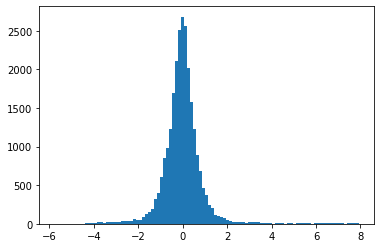

In [165]:
# sample some X to examine
nplot=min(100, train_X.shape[0])
np.random.seed(0)
choices = np.random.choice(train_X.shape[0], nplot, replace=False)

# print("data contain a lot of spikes")
# np.histogram(train_X[1:1000,:].flatten())
# for features,label in train_ds.batch(1).take(10):
#   print(np.histogram(features.numpy().flatten()))
_ = plt.hist(train_X[choices,:].flatten(), bins = 101)

### Median Filter

Thrd = 200000


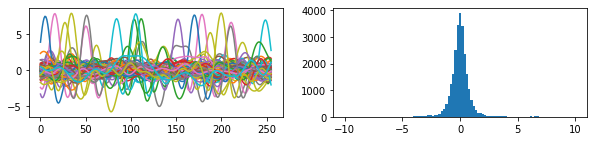

In [166]:
def get_median_filtered(signal, threshold=100):
    """By Bugra"""
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    # if over 10% of data are spikes. return zeros
    if type(mask) is not bool and np.sum(mask) > 0.1 * len(mask):
        return np.zeros(signal.shape)
    return signal

def median_filter(train_X, test_X, thrd):
    train_X = np.array([get_median_filtered(signal, thrd) for signal in train_X])
    test_X = np.array([get_median_filtered(signal, thrd) for signal in test_X])
    return train_X, test_X

def find_best_threshold():
    thrd = 200000
    newX = np.array([get_median_filtered(signal, thrd) for signal in train_X[choices,:]])
    print(f"Thrd = {thrd}")
    _, axs = plt.subplots(1,2,figsize=[10,2])
    for signal in newX:
        axs[0].plot(signal)
    _ = axs[1].hist(newX.flatten(), bins = 101, range=[-10,10])
    return thrd
    
thrd = find_best_threshold()

### Drop out weak channels 

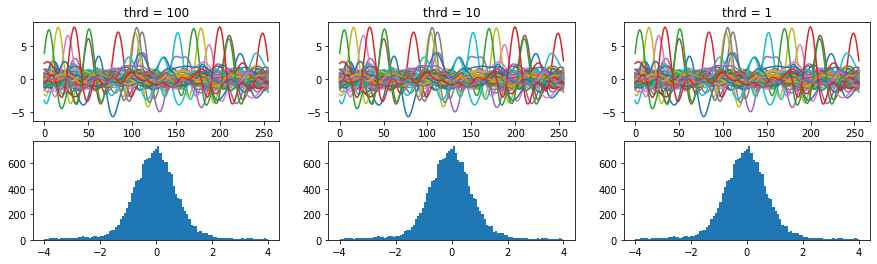

In [167]:
def dropout_weak_channels(train_X, train_y, threshold=1e-3):
    masks = [i for i, signal in enumerate(train_X) if np.sum(np.abs(signal))>threshold]
    train_X = train_X[masks, :, :]
    train_y = train_y[masks, :]
    return train_X, train_y

def find_best_threshold(train_X):
    _, axes = plt.subplots(2, 3, figsize=[15,4])
    for i, scale in enumerate([100, 10, 1]):
        ax = axes[0][i]
        tmp, _ = dropout_weak_channels(train_X, train_X[:,:,0], threshold=scale)
        for signal in tmp:
            ax.plot(signal)
            ax.title.set_text(f"thrd = {scale}")
        axes[1][i].hist(tmp.flatten(), bins = 101, range=[-4,4])


X, _ = median_filter(train_X[choices,:], train_X[choices,:], thrd=20000)
X, _ = dropout_weak_channels(X, X[:,:,0], threshold=100)
find_best_threshold(X)

In [168]:
print("X shape = (samples, timesteps, nfeatures)")
print("y shape = (samples, nfeatures)")
print("")
print("Before processing")
print(f"shape trainX:{train_X.shape}")
print(f"shape trainy:{train_y.shape}")
print(f"shape testX:{test_X.shape}")
print(f"shape testy:{test_y.shape}")
train_X, test_X = median_filter(train_X, test_X, thrd=20000)
train_X, train_y = dropout_weak_channels(train_X, train_y, threshold=100)
test_X, test_y = dropout_weak_channels(test_X, test_y, threshold=100)
print("After processing")
print(f"shape trainX:{train_X.shape}")
print(f"shape trainy:{train_y.shape}")
print(f"shape testX:{test_X.shape}")
print(f"shape testy:{test_y.shape}")

X shape = (samples, timesteps, nfeatures)
y shape = (samples, nfeatures)

Before processing
shape trainX:(62121, 256, 1)
shape trainy:(62121, 1)
shape testX:(37293, 256, 1)
shape testy:(37293, 1)
After processing
shape trainX:(40948, 256, 1)
shape trainy:(40948, 1)
shape testX:(16483, 256, 1)
shape testy:(16483, 1)


In [169]:
# pd.DataFrame({
#     'train': pd.Series(train_y.squeeze()).value_counts(),
#     'test': pd.Series(test_y.squeeze()).value_counts()
# })

### Check data balance

In [170]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 
def balance(train_X, train_y):
    np.random.seed(42)
    nchoices = np.random.choice(range(0, Counter(train_y.squeeze())[0]), Counter(train_y.squeeze())[1], replace=False)
    X1, X2 = train_X[train_y.squeeze()==0,:], train_X[train_y.squeeze()==1,:]
    train_X = np.concatenate([X1[nchoices, :], X2])
    train_y = np.concatenate([train_y[train_y.squeeze()==0][nchoices], train_y[train_y.squeeze()==1]])
    return train_X, train_y
X_res, y_res = balance(train_X, train_y)
print('Resampled dataset shape %s' % Counter(y_res.squeeze()))

Resampled dataset shape Counter({0: 2061, 1: 2061})


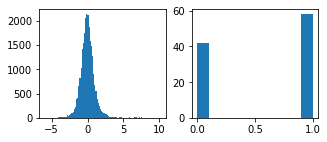

In [171]:
train_X, train_y = X_res, y_res
_, axes = plt.subplots(1, 2, figsize = [5,2])
_ = axes[0].hist(train_X[np.random.choice(range(0,len(train_X)),100), :].flatten(), bins=101)
_ = axes[1].hist(np.random.choice(train_y.squeeze(), 100).flatten())

## Modeling

Try Random Forest Classifier first

In [172]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from scipy.fft import fft

# Shuffling dataset
shuffle = np.random.permutation(len(train_X))

clf = RandomForestClassifier(max_depth=3, random_state=0)
cross_validate(
    clf, 
    np.array(
       [
           [
               np.mean(np.abs(fft(x))), 
               np.mean(np.abs(fft(x))*np.arange(0,len(x)))
           ] 
           for x in train_X[shuffle].squeeze()
       ]
    ), 
    train_y[shuffle].squeeze(), 
    cv=5
)

{'fit_time': array([0.323807  , 0.646667  , 0.54596138, 0.30171585, 0.33038712]),
 'score_time': array([0.01937222, 0.06346512, 0.02068996, 0.01609135, 0.01764083]),
 'test_score': array([0.61575758, 0.61212121, 0.6407767 , 0.63228155, 0.64805825])}

In [176]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization

np.random.seed(0)

model = Sequential()

# model.add(Input(shape=(256,1), name='Input'))
# model.add(Dense(10, activation='relu', name='Dense-1'))

model.add(LSTM(4, activation='sigmoid', return_sequences=True, kernel_regularizer="l1", name='LSTM-1', input_shape=(256,1)))
model.add(Dropout(0.25, name='Dropout-1'))
model.add(BatchNormalization())

model.add(LSTM(2, activation='sigmoid', return_sequences=False, kernel_regularizer="l1", name='LSTM-2'))
model.add(Dropout(0.25, name='Dropout-2'))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid', kernel_regularizer='l1', name='Dense-3'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print(model.summary())

print('start training')
history = model.fit(
        train_X, 
        train_y,
        validation_split=0.2, 
        batch_size=500, 
        epochs=20,
        verbose=1
    )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM-1 (LSTM)                (None, 256, 4)            96        
_________________________________________________________________
Dropout-1 (Dropout)          (None, 256, 4)            0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 256, 4)            16        
_________________________________________________________________
LSTM-2 (LSTM)                (None, 2)                 56        
_________________________________________________________________
Dropout-2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 2)                 8         
_________________________________________________________________
Dense-3 (Dense)              (None, 1)                

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


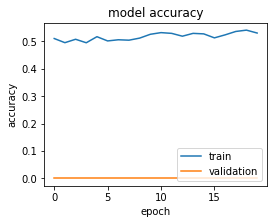

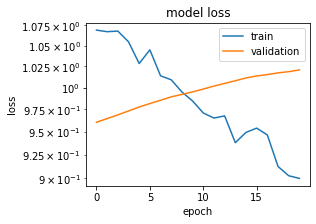

In [178]:
def plot_history(history):
    """Credit=https://stackoverflow.com/q/41908379/13653455"""
    print(history.history.keys())
    #  "Accuracy"
    plt.figure(figsize=[4,3])
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    # "Loss"
    plt.figure(figsize=[4,3])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
plot_history(history)

/Users/yanxlin/opt/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


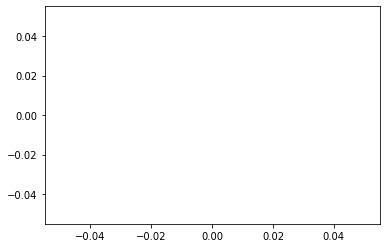

In [273]:
# Compare ROC curve
from sklearn.metrics import roc_curve

fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, model.predict(test_X).ravel())

plt.plot(fpr_keras, tpr_keras)